## PRML ASSIGNMENT-3

In [278]:
import os
import math
import pickle

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from tqdm import tqdm
from prettytable import PrettyTable
from sklearn.feature_extraction.text import CountVectorizer

### 1. Data visualisation

In [279]:
dataframe=pd.read_csv('emails_new.csv')
dataframe.head(5)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [280]:
dataframe.shape

(19651, 2)

Null value detection


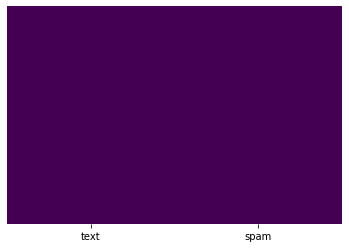

In [281]:
print('Null value detection')
sns.heatmap(dataframe.isnull(),cbar=False,yticklabels=False,cmap='viridis')
plt.show()

In [282]:
#unique value detection..
dup_percentage=(dataframe.duplicated().values.sum()/dataframe.shape[0])*100
print('total % duplicate values',np.round(dup_percentage,2))

#drop the duplicates..
dataframe.drop_duplicates(keep='first',inplace=True)
dataframe.reset_index(drop=True,inplace=True)

total % duplicate values 7.48


In [283]:
dataframe.shape

(18182, 2)

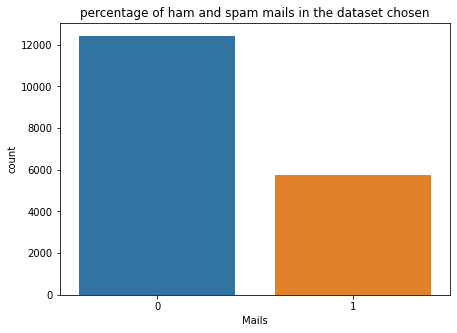

% of ham(0) mails 68.33131668683313
% of Spam(1) emails 31.668683313166866


In [284]:
plt.figure(figsize=(7,5))
ax=sns.countplot(data=dataframe,x='spam')
ax.set_title('percentage of ham and spam mails in the dataset chosen')
ax.set_xlabel('Mails')
plt.show()
v=(dataframe[dataframe['spam']==0].shape[0]/dataframe.shape[0])*100
print("% of ham(0) mails {}\n% of Spam(1) emails {}".format(v,100-v))


In [285]:
def show_sample_mails(Df):
    i=[250,1001,5000,10000,18000]
    sample_ham_mails=[]
    print('Some sample SPAM mails..\n')
    for index in i:
        if Df['spam'][index]==1:
            print(Df['text'][index])
            print()
        else:
            sample_ham_mails.append(Df['text'][index])
            
    print('----'*29)

    print("Some sample HAM mails..\n")
    for hm in sample_ham_mails:
    
        print(hm)
        print('\n')

In [286]:
show_sample_mails(dataframe1)

Some sample SPAM mails..

Subject: set & forget ! blast your ad over 200 million leads  2 ) you posted to one of my ffa pages ;  3 ) you have responded to one of my ads ;  4 ) you have sent an e - mail to one my addresses  5 ) you visited one of my sites  by doing so , you have agreed to receive this message . under bill s .  l 6 l 8 title iii passed by the 105 th us congress this letter cannot be  considered spam as long as the sender includes contact information &  a method of " removal . " however this is a one time mailing so there ' s no  removal required . thank you for your kind consideration .  @ @ @ @ @ @ @ @ @ @ @ @ @ @ disclaimer @ @ @ @ @ @ @ @ @ @ @ @ @

Subject: lose 20 pounds in 10 days 27540  lose weight fast , without special diets or expensive foods  no starving yourself !  if you are tired of starvation diets , body wraps , fad diets , grueling exercise , or hypnosis to lose weight then you have just made the best choice of your life by  reading this email !  we ' re

### 2.Text Preprocessing

In [287]:
def decontracted(phrase):
    # specific
    phrase=re.sub(r"\\\w+","",phrase)
    phrase=re.sub(r"\n","",phrase)
    phrase=re.sub(r"\r","",phrase)
    phrase=re.sub(r"\t","",phrase)
    
    # general
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [288]:
m_spwrd=set(stopwords.words('english'))
m_spwrd.remove('not')
m_spwrd.remove('nor')
m_spwrd.remove('no')

In [289]:
def FtxtP(phrase):
    phrase=decontracted(phrase)
    phrase=re.sub(r"[^A-Za-z0-9]",r" ",phrase)
    phrase=phrase.lower()
    phrase=" ".join(w.strip() for w in phrase.split()[1:] if w not in m_spwrd).strip()
    #phrase=" ".join(PorterStemmer().stem(w) for w in phrase.split()).strip()
    
    return phrase    

In [290]:
dataframe['text']=dataframe['text'].apply(func=FtxtP)
show_sample_mails(dataframe)

Some sample SPAM mails..

set forget blast ad 200 million leads 2 posted one ffa pages 3 responded one ads 4 sent e mail one addresses 5 visited one sites agreed receive message bill l 6 l 8 title iii passed 105 th us congress letter cannot considered spam long sender includes contact information method removal however one time mailing no removal required thank kind consideration disclaimer

lose 20 pounds 10 days 27540 lose weight fast without special diets expensive foods no starving tired starvation diets body wraps fad diets grueling exercise hypnosis lose weight made best choice life reading email not kidding see back lifetime money back guarantee new extreme power plus proven weight loss system details order click url http loseweightfast ad html browsers not accept hyperlinks link not work cut paste browser url box lifetime money back guarantee almost good true extreme power plus time order today get free shipping click http loseweightfast ad html dietary supplements exercise pro

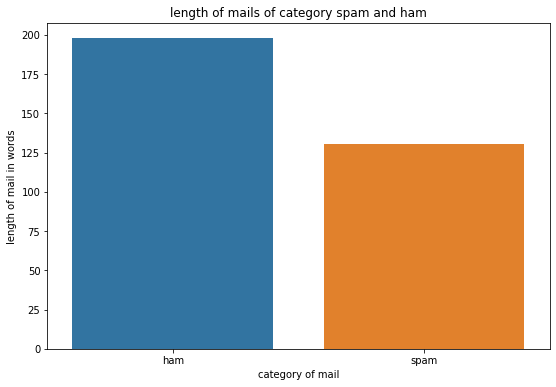

In [291]:
#average length of ham and spam mails

spam_lengths=dataframe[dataframe['spam']==1]['text'].apply(lambda x:len(x.split(' ')))
ham_lengths=dataframe[dataframe['spam']==0]['text'].apply(lambda x:len(x.split(' ')))
avg_spm_length=spam_lengths.values.sum()/spam_lengths.size
avg_ham_length=ham_lengths.values.sum()/ham_lengths.size

fig,ax=plt.subplots(figsize=(9,6))
sns.barplot(x=[0,1],y=[avg_ham_length,avg_spm_length])
ax.set_title('length of mails of category spam and ham')
ax.set_ylabel('length of mail in words')
ax.set_xlabel('category of mail')
ax.set_xticklabels(['ham','spam'])
plt.show()

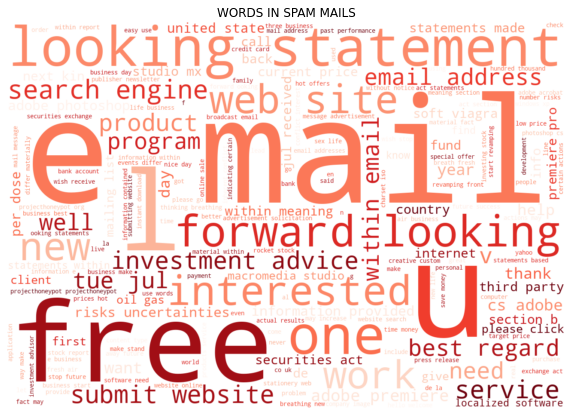

In [292]:
words_sp=""
for mails in dataframe[dataframe['spam']==1]['text'].values:
    words_sp+=mails+" "
words_sp=words_sp.rstrip()

wcsp=WordCloud(height=900,width=1300,background_color='white',colormap='Reds').generate(words_sp)

fig,ax=plt.subplots(figsize=(10,12))
ax.imshow(wcsp,interpolation='bilinear')
ax.axis("off")
ax.set_title('WORDS IN SPAM MAILS')
plt.show()

### 3.Train Test Split

In [293]:
#train test split....
num_dpts=dataframe.shape[0]
indices=np.arange(num_dpts)
shuffled_indices=np.random.permutation(indices)
train_size=math.ceil(num_dpts*0.75)

train=dataframe.iloc[shuffled_indices[:train_size],: ]
train_data=train['text'].values
train_label=train['spam'].values

test=dataframe.iloc[shuffled_indices[train_size:],:]
test_data=test['text'].values
test_label=test['spam'].values

print('Train Data Size : ',train_data.shape)
print('Test Data Size : ',test_data.shape)

Train Data Size :  (13637,)
Test Data Size :  (4545,)


### 4.Algorithm implementations

In [294]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score

def conf_mtx(matrix):
    
    plt.figure(figsize=(7,6))
    ax= plt.subplot()
    sns.heatmap(matrix, annot=True, ax = ax,fmt=".3f",cmap='gist_gray'); 

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
    plt.show()

### 4.1. Naive Bayes .

#### 4.1.1 Vectorizing the text using one hot encoding

In [295]:
#getting the train and test corpus ready..
train_document_corpus=list(train_data.ravel())
test_document_corpus=list(test_data.ravel())

#fitting the vectorizer on train data..
cv=CountVectorizer(binary=True,max_features=15000,ngram_range=(1,1),min_df=3)
cv.fit(train_document_corpus)
dictionary_words=cv.get_feature_names()

#saving the vectorizer to current directory..
if not os.path.exists('NB_params'):
    os.mkdir('NB_params')
    
    with open('NB_params/vectorizer_NB','wb') as f:
        pickle.dump(cv,f)


#transforming train and test.. 
train_ohe=cv.transform(train_document_corpus).toarray()
test_ohe=cv.transform(test_document_corpus).toarray()

In [296]:
#appending 2 dummy entries [1,1,...] corresponding to spam and ham in train..
dummy=[1]*30000

#augmented set of train data and labels for naiva bayes..
train_ohe_nb=np.vstack((train_ohe,np.array(dummy).reshape(2,15000)))
train_label_nb=np.append(train_label,np.array([1,0]))

#### 4.1.2 Training of Naive Bayes

In [297]:
#learn the 2d+1 parameters of naive bayes and stores them.
def Learn_Parameters_NB(Train_data_vectorized,Train_Label):
    
    #getting prior probabilities..
    Prior_spam=Train_Label.sum()/Train_Label.shape[0]
    

    #likelihood probabilities for each word.. 
    word_spam=[]
    word_ham=[]

    sp_mails=Train_data_vectorized[Train_Label==1]
    hm_mails=Train_data_vectorized[Train_Label==0]

    for j in range(Train_data_vectorized.shape[1]):
    
        word_spam.append((np.sum(sp_mails[:,j]))/(sp_mails.shape[0]))
        word_ham.append((np.sum(hm_mails[:,j]))/(hm_mails.shape[0]))
   
    #storing every parameter in NB_params..
    
    with open('NB_params/Prior_spam','wb') as f:
        pickle.dump(Prior_spam,f)
    
    with open('NB_params/word_spam','wb') as f:
        pickle.dump(word_spam,f)
    
    with open('NB_params/word_ham','wb') as f:
        pickle.dump(word_ham,f)
    
    return

#### 4.1.2. Predicting output for Naive Bayes

In [298]:
#To generate the output for test datapoints..

def Predict_NB(Test_Set_vectrorized):
    
    #get the trained parameters using pickle..
    with open('NB_params/Prior_spam','rb') as f:
        Prior_spam=pickle.load(f)
        
    with open('NB_params/word_spam','rb') as f:
        word_spam=pickle.load(f)
    
    with open('NB_params/word_ham','rb') as f:
        word_ham=pickle.load(f)
        
    predicted_labels=[]
    pred_prob_spam=[]
    pred_prob_ham=[]

    for mail in Test_Set_vectrorized:
        log_product_spm=np.log(Prior_spam);log_product_ham=np.log(1-Prior_spam)
        
        for word in range(mail.shape[0]):
            if mail[word]==1:
                log_product_spm+=np.log(word_spam[word])
                log_product_ham+=np.log(word_ham[word])
            
        pred_prob_spam.append(log_product_spm)
        pred_prob_ham.append(log_product_ham)  
        
        
    for idx in range(Test_Set_vectrorized.shape[0]):
    
        if(pred_prob_ham[idx] > pred_prob_spam[idx]):
            predicted_labels.append(0)
        else:
            predicted_labels.append(1)
        
    return predicted_labels

#### 4.1.3. Performance of naive bayes on chosen dataset

In [299]:
#performance of model on the train data..

Learn_Parameters_NB(train_ohe_nb,train_label_nb)
predicted_labels=Predict_NB(test_ohe)

misclassified_mails_1=abs(predicted_labels-test_label).sum()
misclassified_percentage_1=(misclassified_mails_1/test_label.shape[0])*100
accuracy_1=100-misclassified_percentage_1

print("Misclassified mails in %  : ",np.round(misclassified_percentage_1,3))
print("Accuracy in % : ",np.round(accuracy_1,3))

Misclassified mails in %  :  2.376
Accuracy in % :  97.624


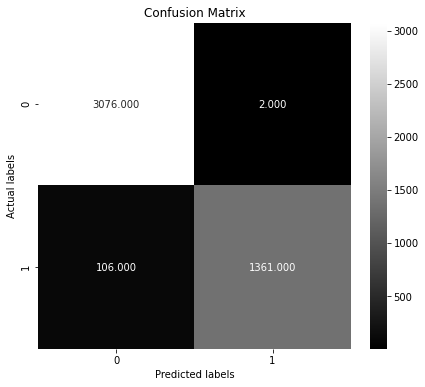

+----------+--------------------+
|  Score   |       Values       |
+----------+--------------------+
| Precison | 0.9985326485693323 |
+----------+--------------------+


In [300]:
conf_mtx(confusion_matrix(y_true=test_label,y_pred=predicted_labels))
pt=PrettyTable()
pt.field_names=['Score','Values']
pt.add_row(['Precison',precision_score(y_true=test_label,y_pred=predicted_labels)])
print(pt)

### 4.2. SVM 

#### 4.2.1. Getting Dataset for Svm from the original dataset but smaller in size

In [301]:
#Getting smaller dataset for svm
Tr_svm=train_data[:5000]
LbTr_svm=train_label[:5000]

Ts_svm=test_data[:2000]
LbTs_svm=test_label[:2000]

print('train for svm ',Tr_svm.shape)
print('test for svm ',Ts_svm.shape)


train for svm  (5000,)
test for svm  (2000,)


#### 4.2.2 vectorizing the text using frequency encoding

In [302]:
#vectorize using the train data:
train_document_corpus_svm=list(Tr_svm.ravel())
#test_document_corpus_svm=list(Ts_svm.ravel())

#text featurization..
cv_svm=CountVectorizer(max_features=3000,ngram_range=(1,1),binary=False,min_df=3)
cv_svm.fit(train_document_corpus_svm)

#saving the vectorizer to current directory..
if not os.path.exists('SVM_params'):
    os.mkdir('SVM_params')
    
    with open('SVM_params/vectorizer_svm','wb') as f:
        pickle.dump(cv_svm,f)

#### 4.2.3 New featurization mail length and polarity of mail

In [303]:
def new_featurizations(Data):
    
    #get mail lengths...
    mail_length=np.array([len(mail.split()) for mail in Data])
    mx1=mail_length.max();min1=mail_length.min()
    mail_length=(mail_length-min1)/(mx1-min1)
    
    #sentiment scores of train and test...
    sen_scores=[]
    senti=SentimentIntensityAnalyzer()

    for mails in Data:
        dict_=senti.polarity_scores(mails)
    
        for key in dict_:
            sen_scores.append(dict_[key])
            
    sen_scores=np.array(sen_scores).reshape(-1,4)
    
    #combine the featurizations done..
    
    new_fetaures=np.hstack((sen_scores,mail_length.reshape(-1,1)))
    
    return new_fetaures


#### 4.2.4. Generating the input data for SVM

In [304]:
def Get_data_ready_for_svm(Data):
    
    #get the corpus for the Data..
    if type(Data) is not list:
        corpus=list(Data.ravel())
    else:
        corpus=Data
    
    #transform using count vectorizer..
    with open('SVM_params/vectorizer_svm','rb') as f:
        cv_svm=pickle.load(f)
    
    part1=cv_svm.transform(corpus).toarray()
    
    #get the additional features added to this dataset..
    new_features=new_featurizations(Data)
    
    #complete input for svm..
    input_to_svm=np.hstack((part1,new_features))
    
    return input_to_svm

In [305]:
train_svm=Get_data_ready_for_svm(Tr_svm)
test_svm=Get_data_ready_for_svm(Ts_svm)

In [306]:
print('input training data size for Svm : ',train_svm.shape)
print('input test data size for Svm : ',test_svm.shape)

input training data size for Svm :  (5000, 3005)
input test data size for Svm :  (2000, 3005)


#### 4.2.5 Common functions for SVM

In [307]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

def Run_SVM(train,label,C):
  
    clf=SVC(C=C,kernel='linear',class_weight='balanced',gamma='auto')
    clf.fit(train,label)
    return clf    

In [308]:
def accuracy_plot(grid_C,avg_train_acc,avg_cv_acc):
    plt.figure(figsize=(8,6))
    plt.plot(np.log10(C),avg_train_acc,label='train')
    plt.plot(np.log10(C),avg_cv_acc,label='cross validation data')
    plt.title('accuracy for diff values of C')
    plt.xlabel('log10 C')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

#### 4.2.6. 3-fold cross validation for optimal C

In [309]:
def k_fold_cv(grid_C,Train,Label,K):
    
    fold_size=Train.shape[0]//K
    avg_train_acc=[];avg_cv_acc=[]
    for c in tqdm(grid_C):
        
        train_auc=0;cv_auc=0
        for fold_no in range(K):
            
            X_tr=np.full((1,Train.shape[1]),0)
            Y_tr=[]
            
            for itr in range(K):
                
                left_range=itr*fold_size
                right_range=(itr+1)*fold_size
            
                #cv data
                if(itr==fold_no):
                    X_cv=Train[left_range:right_range,:]
                    Y_cv=Label[left_range:right_range]
            
                else:
                    X_tr=np.vstack((X_tr,Train[left_range:right_range,:]))
                    Y_tr.extend(Label[left_range:right_range])
                
        
            X_tr=X_tr[1:,:]
            Y_tr=np.array(Y_tr)
            
            clf=Run_SVM(X_tr,Y_tr,c)
            pred_tr=clf.predict(X_tr)
            pred_cv=clf.predict(X_cv)
            
            train_auc+=1-(abs(Y_tr-pred_tr).sum()/Y_tr.shape[0])
            cv_auc+=1-(abs(Y_cv-pred_cv).sum()/Y_cv.shape[0])
            
        avg_train_acc.append(train_auc/K)
        avg_cv_acc.append(cv_auc/K)
    
    return (avg_train_acc,avg_cv_acc)

100%|██████████| 12/12 [16:35<00:00, 82.94s/it]


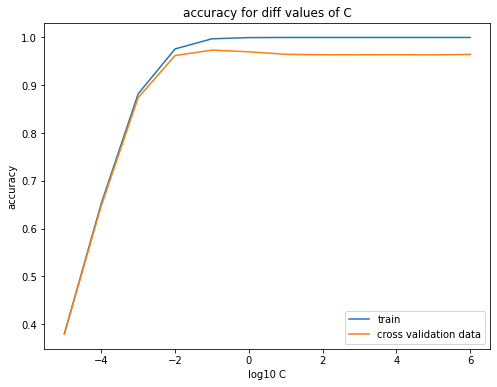

In [310]:
C=[10**i for i in range(-5,7)]
avg_train_acc,avg_cv_acc=k_fold_cv(C,train_svm,LbTr_svm,3)
accuracy_plot(C,avg_train_acc,avg_cv_acc)

#### 4.2.7. Performance of SVM on the chosen Dataset

In [311]:
#Store the classifier with optimal value of hyperparameter..
clf=Run_SVM(train_svm,LbTr_svm,1)
with open('SVM_params/classifier_svm','wb') as f:
        pickle.dump(clf,f)

#getting accuracy for the train set..
predicted_labels2=clf.predict(test_svm)

miclfd_pts2=(abs(predicted_labels2-LbTs_svm).sum()/LbTs_svm.shape[0])*100
acc2=100-miclfd_pts2
print('missclassified points ',miclfd_pts2)
print('Accuracy on sample test data : ',acc2)

missclassified points  2.45
Accuracy on sample test data :  97.55


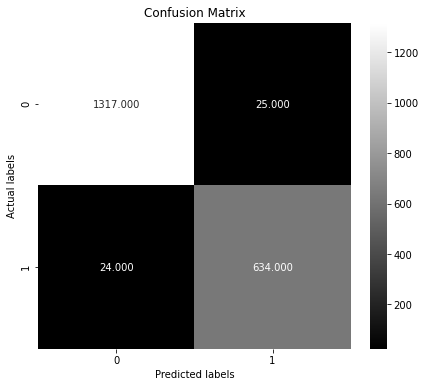

+----------+--------------------+
|  Score   |       Values       |
+----------+--------------------+
| Precison | 0.9620637329286799 |
+----------+--------------------+


In [312]:
conf_mtx(confusion_matrix(y_true=LbTs_svm,y_pred=predicted_labels2))
pt=PrettyTable()
pt.field_names=['Score','Values']
pt.add_row(['Precison',precision_score(y_true=LbTs_svm,y_pred=predicted_labels2)])
print(pt)

### 5.Predictions for the test file 

#### 5.1. Prediction using Naive Bayes

In [317]:
def get_output_using_NB(corpus):
    
    #Do one hot encoding..
    with open('NB_params/vectorizer_NB','rb') as f:
        cv_nb=pickle.load(f)
    
    corpus_ohe=cv_nb.transform(corpus).toarray()
    
    #predict using Naive bayes..
    predicted_labels=Predict_NB(corpus_ohe)
    
    #append the output in output_nb.txt file..
    with open('output_nb.txt','w') as f:
        for vals in predicted_labels:
            f.write(str(vals)+'\n')
    
    return

#### 5.2 Prediction using SVM

In [318]:
def get_output_using_SVM(corpus):
    
    #Do encoding for svm..
    input_data=Get_data_ready_for_svm(corpus)
    
    #predict using saved classifier for svm..
    with open('SVM_params/classifier_svm','rb') as f:
        clf_svm=pickle.load(f)
    
    predicted_labels=clf_svm.predict(input_data)
    
    #append the output in output_svm.txt file..
    with open('output_svm.txt','w') as f:
        for vals in predicted_labels:
            f.write(str(vals)+'\n')
    
    return

#### 5.3. Function to read the .txt files from 'test' folder in the current directory and generate 2 set of outputs for naive bayes and svm.

In [319]:
def Get_Outputs_for_Test():
    
    #collect the files in a test_corpus..
    path='test/'
    test_corpus=[]
    files=os.listdir(path)
    for file in files:
    
        if file=='.DS_Store':
            continue
    
        new_path=path+file
        with open(new_path,'r') as f:
            content=f.readlines()
            content=" ".join(word for word in content)
            test_corpus.append(content)

    
    #text preprocessing..
    for i in range(len(test_corpus)):
        test_corpus[i]=FtxtP(test_corpus[i])
    
    get_output_using_NB(test_corpus)
    
    get_output_using_SVM(test_corpus)
    
    return

In [320]:
Get_Outputs_for_Test()